Jason Pettinato; jpettinato@umass.edu


**Question 1** (5 points) - **Test data**.

Here is a function to generate a context (just a scalar) and an output (also just a scalar)

```python
def get_data_generator(batchsize):
    def getbatch(key):
        key, subkey = jax.random.split(key)
        context = 10*jax.random.uniform(subkey, [batchsize])
        key, subkey = jax.random.split(key)
        output = 3 + 10 * context - 0.7 * context**2 + jax.random.normal(subkey, [batchsize])
        return context, output
    return getbatch
```

Write code to draw 100 inputs and outputs and plot them. Give your full code as well as the plot as your answer in the report.

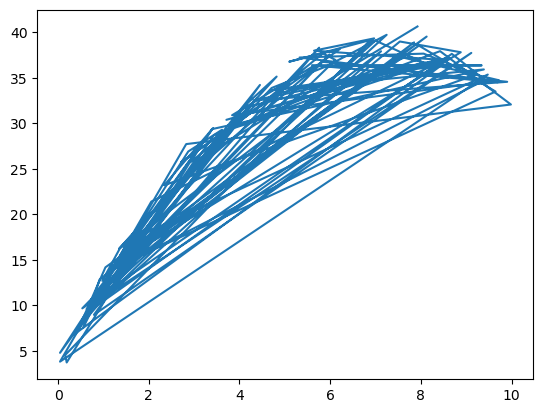

In [11]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

def get_data_generator(batchsize):
    def getbatch(key):
        key, subkey = jax.random.split(key)
        context = 10*jax.random.uniform(subkey, [batchsize])
        key, subkey = jax.random.split(key)
        output = 3 + 10 * context - 0.7 * context**2 + jax.random.normal(subkey, [batchsize])
        return context, output
    return getbatch
    
getbatch = get_data_generator(100)
key = jax.random.PRNGKey(100)
context, output = getbatch(key)

plt.plot(context, output)


**Question 2** (10 points) - **Optimization**


When you call `signed_gradient_descent(net, loss, getbatch, max_iter, learning_rates, *params)`, this function tries to find values for `params` so that if you do

```python
context, output = getbatch(key)
pred = net(context, *params)
loss(pred, output)
```

then the average value of loss (over different choices for `key`) will be as low as possible. It does this by doing a total of `max_iter` number of iterations of signed gradient descent. It uses the different step-sizes in `learning_rates` for equal fractions of iterations. (For example, if `max_iter=100` and `learning_rates=[0.1, 0.05]` it will do 50 iterations with a learning rate of 0.1, and 50 iterations with a learning rate of 0.05.)

Let's test this function.  Use the following `net` and `loss`:

For each of the following settings, please report:

- The total time taken by optimization
- The final parameters found
- The smooth loss at the end of optimization


Give your results as a table, with one row for each of the 5 settings, and one column for time, three columns for the three parameters, and 1 column for the smooth loss at the end of optimization. Please also report your full code (directly in your report). Include *everything* except the code for `signed_gradient_descent`.


In [11]:
import jax
import numpy as np
import matplotlib.pyplot as plt

print(jax.devices())


[CpuDevice(id=0)]


In [12]:
cases = {
    "one": {'batch_size': 1, 
            'max_iter': 1000,
            'learning_rates': [0.1]},
    'two':  {'batch_size': 10, 
            'max_iter': 1000,
            'learning_rates': [0.1]},
    'three': {'batch_size': 100, 
            'max_iter': 1000,
            'learning_rates': [0.1]},
    'four': {'batch_size': 100, 
            'max_iter': 1000,
            'learning_rates': [0.01]},
    'five': {'batch_size': 100, 
            'max_iter': 1000,
            'learning_rates': [0.1, 0.01]},
}

In [13]:

key = jax.random.PRNGKey(0)
a = jax.random.normal(key, 1)
b = jax.random.normal(key, 1)
c = jax.random.normal(key, 1)

In [15]:
import jax
from jax import flatten_util
from jax import numpy as jnp
from typing import Callable
import time



def signed_gradient_descent(net: Callable, loss: Callable, getbatch: Callable, max_iter: int, learning_rates: list[int], *params):
    assert isinstance(net,Callable)
    assert isinstance(loss,Callable)
    assert isinstance(getbatch,Callable)
    assert isinstance(max_iter,int)

    key = jax.random.PRNGKey(0)
    w, unflatten = jax.flatten_util.ravel_pytree(params)

    # batch predictive network over context, but not params
    batched_net = jax.vmap(net,[0]+[None]*len(params))
    # batch loss over both context and predictions
    batched_loss = jax.vmap(loss)

    def l(key,w):
        params = unflatten(w)
        context, next = getbatch(key)
        pred = batched_net(context,*params)
        return jnp.mean(batched_loss(pred, next))

    fun = jax.value_and_grad(l,1)

    t0 = time.time()

    avg_grad = 0
    avg_loss = 0
    smooth_loss = 0

    print(" iter     l.r.     loss (smooth)    (avg)     time")
    print("----- -------- -------- -------- -------- --------")
    for i in range(max_iter):
        n = int(i * len(learning_rates) / max_iter)

        key, subkey = jax.random.split(key)
        loss, grad = fun(subkey, w)
        avg_loss = (i*avg_loss + loss)/(i+1)
        alpha = max(.01,1/(i+1))
        smooth_loss = alpha*loss + (1-alpha) * smooth_loss

        if i % (max_iter // 20) == 0:
            print(f"{i: >5} {learning_rates[n]:8.5f} {loss:8.5f} {smooth_loss:8.5f} {avg_loss:8.5f} {time.time()-t0:8.5f}")
        avg_grad = 0.9 * avg_grad + 0.1 * grad

        w = w - learning_rates[n]*jnp.sign(avg_grad)
    if len(params)==1:
        return unflatten(w)[0]
    else:
        return unflatten(w)

In [16]:

def net(context,a,b,c):
    return a + b*context + c*context**2

def loss(pred, output):
    return (pred - output)**2

In [16]:
for key in cases:
    batch_size = cases[key]['batch_size']
    max_iter = cases[key]['max_iter']
    learning_rates = cases[key]['learning_rates']
    print(f'For batch size {batch_size}, max iterations {max_iter}, and learning rates {learning_rates} \n')
    # Pass parameters as positional arguments after the required arguments
    result = signed_gradient_descent(
        net,            # first positional arg
        loss,           # second positional arg
        get_data_generator(batch_size),  # third positional arg
        max_iter,       # fourth positional arg
        learning_rates, # fifth positional arg
        a, b, c        # remaining parameters passed as *params
    )
    print(result)

For batch size 1, max iterations 1000, and learning rates [0.1] 

 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.10000 3266.41748 3266.41748 3266.41748  0.38729
   50  0.10000 600.59363 600.44720 600.44739  0.92214
  100  0.10000 670.92487 501.67975 501.66263  1.36629
  150  0.10000  1.37652 484.13324 488.17874  1.77671
  200  0.10000 61.12024 336.29819 393.60062  2.19863
  250  0.10000 847.08722 275.99393 348.28839  2.64650
  300  0.10000 321.85944 238.15434 321.49908  3.11203
  350  0.10000 55.96746 225.99034 303.91617  3.58436
  400  0.10000 109.21233 192.34531 284.02496  4.03320
  450  0.10000 14.45440 179.75510 269.11960  4.49688
  500  0.10000 76.08011 143.60419 251.76328  4.97738
  550  0.10000 119.08146 178.08289 249.14088  5.50639
  600  0.10000 270.24194 247.87230 261.00519  5.99078
  650  0.10000  1.92052 269.25809 265.03439  6.54097
  700  0.10000 12.53912 232.15305 259.18713  7.07647
  750  0.10000 1859.81299 


**Question 3** (10 points) - **Hyper-parameters**

Please comment on:

1. How does the total time seem to depend on the batchsize and the learning rates?
2. How does the quality of the final parameters seem to depend on the batchsize and learning rates? (Hint: look at `get_data_generator` above to guess what the true optimal parameters are.)
3. How does the final smooth loss seem to depend on the batchsize and learning rates?

___
1. As batch size increases, time decreases
2. Given that we have the function: output = 3 + 10 * context - 0.7 * context**2 + jax.random.normal(subkey, [batchsize]), where a=3, b=10, c=-0.7, let's look at how the function approximation looks. The best performing one is when lr=0.01, batch-size=100. The worst performing is lr=0.1, batch-size=1. We can infer that both of these paramters have a positive impact on the final performance. This is further supported by the discrepancy between cases 2-3 (when the batch size is varied), and when lr is varied between 0.1 to 0.001. In both cases these independant variables give an increase in estimation performance.
3. Smooth loss is highly dependent on learning rate (40x decrease from 0.1 to 0.01). For batch size it has a similar decrease (10x decrease in loss for 10x increase in batch size). It appears that the learning rate decrease has a higher impact than batch size.
___

**Question 4** (5 points) - **Training data**

**Data Download**: You may download the training data here: [data.npz](https://people.cs.umass.edu/domke/data.npz).

You will be given a file `data.npz`. This contains a single array, `data` of length 494,769,199. This array contains integers of type `uint8`, meaning each entry of the array is stored in a single byte. So storing this array will require around half a gigabyte of memory.

This array contains the full contents of 100 books from Project Gutenberg. There are 72 possible characters, which are represented by the integers `0, 1, ..., 71`. The integers can be mapped to characters using the following list:

```python
chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '?', ':', '"', "'", '+', ',', '.', ' ', '\\n']
```

For example, the first 20 entries of `data` are

```python
start = array([55, 17, 14, 70, 51, 27, 24, 19, 14, 12, 29, 70, 42, 30, 29, 14, 23,
       11, 14, 27, 16, 70, 40, 37, 24, 24, 20, 70, 24, 15, 70, 55, 17, 14,
       70, 40, 25, 18, 12, 70, 24, 15, 70, 54, 10, 30, 21, 68, 70, 11, 34,
       70, 58, 18, 21, 21, 18, 10, 22, 70, 38, 21, 14, 10, 31, 14, 27, 70,
       58, 18, 21, 20, 18, 23, 28, 24, 23], dtype=int8)

```

Convert these entries to a string with this command.

```python
''.join([chars[c] for c in start])
```

What does this command result in?

___
'The Project Gutenberg EBook of The Epic of Saul, by William Cleaver Wilkinson'
___


**Question 5** (10 points) - **Data loader**

To save memory, you should load the data in "memory-mapped" mode, with the command

```python
data = np.load('data.npz',mmap_mode='r')['data']
```

This means data is only loaded from disk as needed. For convenience, we provide the following command which can load a "batch" of data.

```python
def get_data_generator(context_size, batch_size):
    def getbatch(key):
        key, subkey = jax.random.split(key)
        start = jax.random.randint(subkey, shape=batch_size, minval=0, maxval=len(data)-context_size)
        indices = start[:,None] + np.arange(context_size)[None,:]
        indices = start[:,None] + np.arange(context_size)[None,:]
        context = data[indices] # (batchsize x context_size)
        next = data[start+context_size] # (batchsize,)
        return context, next
    return getbatch
```

Load the data and run the following commands:

```python
import jax
key = jax.random.PRNGKey(0)
getbatch = get_data_generator(50, 5)
context, next = getbatch(key)
```

Please answer each of the following questions in at most 2 sentences each:

**A)** What are the shapes of `context` and `next`?

**B)** What is contained in the arrays `context` and `next`?

**C)** What role does `key` play?

In [17]:
import numpy as np
data = np.load('data.npz',mmap_mode='r')['data']


def get_data_generator(context_size, batch_size):
    def getbatch(key):
        key, subkey = jax.random.split(key)
        start = jax.random.randint(subkey, shape=batch_size, minval=0, maxval=len(data)-context_size)
        indices = start[:,None] + np.arange(context_size)[None,:]
        indices = start[:,None] + np.arange(context_size)[None,:]
        context = data[indices] # (batchsize x context_size)
        next = data[start+context_size] # (batchsize,)
        return context, next
    return getbatch

import jax
key = jax.random.PRNGKey(0)
getbatch = get_data_generator(50, 5)
context, next = getbatch(key)

___
A.) The shapes are (5,60) and (5), respectively

B.) Context are character values (using the mapping in the previous question). The value 5 is the number of batches, and the values 60 is the number of characters in the batch. Next is the 'true value' of the next character. This will likely be used as our Y value during training

C.) Key is used to decide how the data will be split up for batching.
___


**Question 6** (10 points) - **Simplest possible net**

In this assignment, you will implement a series of increasingly powerful networks. Each of these will predict the next character given a context window of the most recent text.


In this first one, you will implement a "constant" network that simply ignores the context and always predicts a constant vector.

Train this network using a `batchsize` of 4096, a `context_size` of 32, 10000 iterations, and `learning_rates=[0.001, 0.0001]`.

Initialize `b` with `jnp.zeros(num_characters)`.

In your solution, give your full code to do learning, along with the full output trace. Show all of your code except for the text of `signed_gradient_descent`.

Hint: Do not overthink your implementation of `constant_net`!

In [18]:
import jax.numpy as jnp
from jax.nn import logsumexp
import numpy as np

def get_data_generator(context_size, batch_size):
    def getbatch(key):
        key, subkey = jax.random.split(key)
        start = jax.random.randint(subkey, shape=batch_size, minval=0, maxval=len(data)-context_size)
        indices = start[:,None] + np.arange(context_size)[None,:]
        indices = start[:,None] + np.arange(context_size)[None,:]
        context = data[indices] # (batchsize x context_size)
        next = data[start+context_size] # (batchsize,)
        return context, next
    return getbatch


def los(pred,next):
    assert pred.shape == (num_characters,)
    assert next.shape == ()
    log_probs = pred - logsumexp(pred)
    assert log_probs.shape == (num_characters,)
    next_onehot = jax.nn.one_hot(next, num_classes=num_characters)
    assert next_onehot.shape == (num_characters,)
    out = -jnp.sum(log_probs * next_onehot)
    assert out.shape == ()
    return out


def constant_net(context, b):
    # input context is a 1-D array of size context_size
    # each entry is an index between 0 and num_characters
    # these represent the most recent characters
    (context_size,) = context.shape
    (num_characters,) = b.shape

    pred = np.zeros(num_characters) # Constant vector

    assert pred.shape == (num_characters,)
    return pred


chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '?', ':', '"', "'", '+', ',', '.', ' ', '\n']

batch_size = 4096
context_size = 32
n_iter = 10000
learning_rates = [0.001, 0.0001]
num_characters = len(chars)
b = jnp.zeros(num_characters)

key = jax.random.PRNGKey(0)
getbatch = get_data_generator(context_size, batch_size)
context, next = getbatch(key)

signed_gradient_descent(constant_net, los, getbatch, n_iter, learning_rates,b)

 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.00100  4.27667  4.27667  4.27667  0.22560
  500  0.00100  4.27667  4.27667  4.27665  5.94237
 1000  0.00100  4.27667  4.27667  4.27666 12.01368
 1500  0.00100  4.27667  4.27667  4.27672 18.50032
 2000  0.00100  4.27667  4.27667  4.27670 25.29376
 2500  0.00100  4.27667  4.27667  4.27663 32.00379
 3000  0.00100  4.27667  4.27667  4.27661 38.66042
 3500  0.00100  4.27667  4.27667  4.27661 45.29550
 4000  0.00100  4.27667  4.27667  4.27664 51.88955
 4500  0.00100  4.27667  4.27667  4.27672 58.46129
 5000  0.00010  4.27667  4.27667  4.27678 65.03401
 5500  0.00010  4.27667  4.27667  4.27685 71.85726
 6000  0.00010  4.27667  4.27667  4.27685 78.55393
 6500  0.00010  4.27667  4.27667  4.27685 85.35452
 7000  0.00010  4.27667  4.27667  4.27685 92.24264
 7500  0.00010  4.27667  4.27667  4.27685 99.61116
 8000  0.00010  4.27667  4.27667  4.27687 107.20030
 8500  0.00010  4.27667  4.276

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)


**Question 7** (5 points) - Generating from the simplest test

You can use the following code to “generate” from your network.


In [18]:

char2int = dict(zip(chars, range(len(chars))))

def generate_char(net,context,key,*params):
    pred = net(context,*params);
    assert pred.shape == (num_characters,)
    out = jax.random.categorical(key, pred);
    assert out.shape == ()
    return out


def generate(net,context_str,context_size,num_char,*params):
    context = [char2int[c] for c in context_str]

    key = jax.random.PRNGKey(1)
    for i in range(num_char):
        key, subkey = jax.random.split(key)
        my_context = jnp.array(context[-context_size:])
        c = generate_char(net,my_context,subkey,*params)
        context.append(int(c))

    out = ''.join([chars[i] for i in context])

    return out

In [ ]:

import numpy as np
data = np.load('data.npz',mmap_mode='r')['data']


def get_data_generator(context_size, batch_size):
    def getbatch(key):
        key, subkey = jax.random.split(key)
        start = jax.random.randint(subkey, shape=batch_size, minval=0, maxval=len(data)-context_size)
        indices = start[:,None] + np.arange(context_size)[None,:]
        indices = start[:,None] + np.arange(context_size)[None,:]
        context = data[indices] # (batchsize x context_size)
        next = data[start+context_size] # (batchsize,)
        return context, next
    return getbatch

import jax
key = jax.random.PRNGKey(0)
getbatch = get_data_generator(50, 5)
context, next = getbatch(key)

char2int = dict(zip(chars, range(len(chars))))

def generate_char(net,context,key,*params):
    pred = net(context,*params);
    assert pred.shape == (num_characters,)
    out = jax.random.categorical(key, pred);
    assert out.shape == ()
    return out


def generate(net,context_str,context_size,num_char,*params):
    context = [char2int[c] for c in context_str]

    key = jax.random.PRNGKey(1)
    for i in range(num_char):
        key, subkey = jax.random.split(key)
        my_context = jnp.array(context[-context_size:])
        c = generate_char(net,my_context,subkey,*params)
        context.append(int(c))

    out = ''.join([chars[i] for i in context])

    return out

In [20]:

start = "STUDENT:\nI have searched the skies and found...\n\nTEACHER:\nYes? What have you found?\n\nSTUDENT\nI have found a fact, a fact most excellent.\n"
b_constant = jnp.zeros(num_characters)
print(generate(constant_net,start,context_size,500,b_constant))

STUDENT:
I have searched the skies and found...

TEACHER:
Yes? What have you found?

STUDENT
I have found a fact, a fact most excellent.
vbQfrtt9y,1V P
lvQq:7B:uAIk.:,lRxQwZPU '
YNPaNo gQg3mV0DG+3QC"x!Jb43Q3KwNJR"3'i9c,PG?"OX3GpQDToMyx1:Aycvkv+kbzq0M.:Qh,I uengXhLe4
I6"aG5lr+!0woV9ILupClt77Dxw
CS"6.l'RN2uLDbp41y34Uob.HSi"1cbOZSFWwK
wc,ECE4QlCebY"H2lGRpckjLLMWq444Z,PUS"dPhII?Pk:c.qsZSBSmEl!R rnYLriBEEhJo2OAMU5sLh9?DGX!3IJ.bcWl7!YmLeZbTCV2csw2W,b2iWx 9AExMTh?E'+'zP6ehOKel7lfuQ'0hSs9iad"jj+ifveAiLIp
d2fDV6RRfyzqpSs':VHJpfozcPX?okMd'J yBR,5m"0!Y+6"jSeEsV!3'Vg52iPQN3'Pm'Azh"dNui22N!49
Ci! ,fMB!DBW'UmcY9gddBQdcfudT.1odz,Sg?7U P4WLB!hEX



**Question 8** (10 points) - **Linear net**

In this problem, you should implement a more powerful "linear" predictor of the next few characters, with the following function signature.

The linear net should take in a given context, along with a weight matrix `W` and a bias vector `b` to produce a prediction vector `pred` of size `num_characters` which represents the probabilities/score of each character being the next character following the context.

In your solution, give your full code to do learning, along with the full output trace. Show all of your code except for the text of `signed_gradient_descent`.

In [21]:
import jax.numpy as jnp
from jax.nn import logsumexp

def los(pred,next):
    assert pred.shape == (num_characters,)
    assert next.shape == ()
    log_probs = pred - logsumexp(pred)
    assert log_probs.shape == (num_characters,)
    next_onehot = jax.nn.one_hot(next, num_classes=num_characters)
    assert next_onehot.shape == (num_characters,)
    out = -jnp.sum(log_probs * next_onehot)
    assert out.shape == ()
    return out

def linear_net(context, b, W):
    (context_size,) = context.shape

    (context_size2, num_characters, num_characters2) = W.shape
    assert context_size == context_size2
    assert num_characters == num_characters2

    context_onehot = jax.nn.one_hot(context, num_classes=num_characters)
    assert context_onehot.shape == (context_size, num_characters)

    # Einsum is used for more efficent tensor product since we need to sum over all axes in one location
    # W is shape (32, 72, 72)
    # Context_onehot is shape (32, 72)
    # The desired shape is 72, so we need to multiply the first two axes and sum over them.
    pred = b + jnp.einsum('ij,ijk->k', context_onehot, W)

    assert pred.shape == (num_characters,)
    return pred

chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '?', ':', '"', "'", '+', ',', '.', ' ', '\n']
batch_size = 4096
context_size = 32
n_iter = 10000
learning_rates = [0.001, 0.0001]
num_characters = len(chars)

b_linear = jnp.zeros(num_characters)
W_linear = jnp.array(.01*np.random.randn(context_size, num_characters, num_characters))


# Training
key = jax.random.PRNGKey(0)
getbatch = get_data_generator(context_size, batch_size)
context, next = getbatch(key)

# Single call to signed_gradient_descent
b_linear, W_linear = signed_gradient_descent(
    linear_net, 
    los, 
    get_data_generator(context_size, batch_size),
    n_iter, 
    learning_rates,
    b_linear,
    W_linear
)

 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.00100  4.27094  4.27094  4.27094  0.23683
  500  0.00100  2.56129  2.63318  2.83816 18.49372
 1000  0.00100  2.37623  2.39669  2.64384 36.03025
 1500  0.00100  2.33822  2.31457  2.54024 52.82537
 2000  0.00100  2.29818  2.28207  2.47771 69.86206
 2500  0.00100  2.26421  2.27185  2.43730 86.71395
 3000  0.00100  2.28726  2.27310  2.40967 103.83498
 3500  0.00100  2.24707  2.27570  2.39046 120.83046
 4000  0.00100  2.29157  2.28118  2.37653 137.53218
 4500  0.00100  2.28145  2.28403  2.36632 154.46834
 5000  0.00010  2.28235  2.29063  2.35876 172.81121
 5500  0.00010  2.30294  2.28773  2.35251 190.95954
 6000  0.00010  2.29192  2.28485  2.34699 207.97517
 6500  0.00010  2.35770  2.28827  2.34227 224.90945
 7000  0.00010  2.31603  2.28488  2.33806 242.19482
 7500  0.00010  2.24753  2.28746  2.33462 259.21468
 8000  0.00010  2.26785  2.28614  2.33160 276.23210
 8500  0.00010  2.27


**Question 9** (5 points) - **Generating from the linear net**

Generate outputs from your network and show the resulting output at text. It should be noticeably better than the constant network, although still not great.

In [22]:
char2int = dict(zip(chars, range(len(chars))))

def generate_char(net,context,key,*params):
    pred = net(context,*params);
    assert pred.shape == (num_characters,)
    out = jax.random.categorical(key, pred);
    assert out.shape == ()
    return out


def generate(net,context_str,context_size,num_char,*params):
    context = [char2int[c] for c in context_str]

    key = jax.random.PRNGKey(1)
    for i in range(num_char):
        key, subkey = jax.random.split(key)
        my_context = jnp.array(context[-context_size:])
        c = generate_char(net,my_context,subkey,*params)
        context.append(int(c))

    out = ''.join([chars[i] for i in context])

    return out

start = "STUDENT:\nI have searched the skies and found...\n\nTEACHER:\nYes? What have you found?\n\nSTUDENT\nI have found a fact, a fact most excellent.\n"
b_constant = jnp.zeros(num_characters)
print(generate(linear_net, start,context_size, 500, b_linear, W_linear))

STUDENT:
I have searched the skies and found...

TEACHER:
Yes? What have you found?

STUDENT
I have found a fact, a fact most excellent.

 of the   s bllige the Amby whe probe d
 "Prup of hmuthare thacllay
d were  or canit the pestory: "Arcutwa cherragr at tenginee,
Ithale, as woted upolt  haverobe.


N CLDecaly tiol. Sin centim, of caringelleby tho dpaknes somes aiof dof aree cosstichm ls orne tion anorsedens he ther ablotele! meer ond cow ton ine beem The rom
Painatel ufuthengsoind coniag witho
d mante foreple ton proflyono
Mack are, mather theessadlougenin sizemethind uinne s inis ffrocher fice of
Bricturn. He tasty he wall be



**Question 10** (10 points) - **MLP Net**

In this problem, you should implement a more complicated MLP (multi-layer perceptron) net predictor of the next few characters, with the following function signature.
****The MLP net should take in a given context, along with weight matrices `W`, `V` and bias vectors `b`, `c` to produce a prediction vector `pred` of size `num_characters`. The prediction vector contains the probabilities/score of each character being the next character following the context.

The weight matrix `V` and bias vector `c` defines the first layer, while the weight matrix `W` and bias vector `b` defines the second layer. You should use a ReLU activation between the two layers. Hint: you should use jax.nn.relu() function. 

Train this network using a `batchsize` of 4096, a `context_size` of 32, 10000 iterations, and `learning_rates=[0.001, 0.0001]`.

In your solution, give your full code to do learning, along with the full output trace. Show all of your code except for the text of `signed_gradient_descent`. 

**Note**: Initializing the `W` and `V` to small random numbers actually matters to the training. And the training of this model will take a significant amount of time. Be prepared to expect a long running time (~1 hour).

In [23]:

def get_data_generator(context_size, batch_size):
    def getbatch(key):
        key, subkey = jax.random.split(key)
        start = jax.random.randint(subkey, shape=batch_size, minval=0, maxval=len(data)-context_size)
        indices = start[:,None] + np.arange(context_size)[None,:]
        indices = start[:,None] + np.arange(context_size)[None,:]
        context = data[indices] # (batchsize x context_size)
        next = data[start+context_size] # (batchsize,)
        return context, next
    return getbatch


def los(pred,next):
    assert pred.shape == (num_characters,)
    assert next.shape == ()
    log_probs = pred - logsumexp(pred)
    assert log_probs.shape == (num_characters,)
    next_onehot = jax.nn.one_hot(next, num_classes=num_characters)
    assert next_onehot.shape == (num_characters,)
    out = -jnp.sum(log_probs * next_onehot)
    assert out.shape == ()
    return out

In [24]:
import jax.numpy as jnp
import numpy as np
import jax
from jax.nn import logsumexp

chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '?', ':', '"', "'", '+', ',', '.', ' ', '\n']

@jax.jit
def mlp_net(context, b, c, W, V):
    #assert context.shape == (context_size,)
    (context_size,) = context.shape
    (num_characters,) = b.shape
    (num_hidden,) = c.shape
    (num_characters, num_characters2) = W.shape
    (context_size, num_characters, num_hidden) = V.shape

    context_onehot = jax.nn.one_hot(context, num_classes=num_characters)
    assert context_onehot.shape == (context_size, num_characters)
    hidden_1 = c + jnp.einsum('ij,ijk->k', context_onehot, V)
    pred = b + jnp.einsum('ij,j->i', W, hidden_1)

    assert pred.shape == (num_characters,)
    return pred

num_hidden = 500
batch_size = 4096
context_size = 32
n_iter = 10000
learning_rates = [0.001, 0.0001]
num_characters = len(chars)
b_mlp = jnp.zeros(num_characters)
c_mlp = jnp.zeros(num_hidden)
W_mlp = jnp.array(.01*np.random.randn(num_characters, num_hidden))
V_mlp = jnp.array(.01*np.random.randn(context_size, num_characters, num_hidden))


# Training
key = jax.random.PRNGKey(0)
getbatch = get_data_generator(context_size, batch_size)
context, next = getbatch(key)

# Single call to signed_gradient_descent
result = signed_gradient_descent(
    mlp_net, 
    los, 
    get_data_generator(context_size, batch_size),
    n_iter, 
    learning_rates,
    b_mlp,
    c_mlp,
    W_mlp,
    V_mlp
)


 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.00100  4.27589  4.27589  4.27589  0.36090
  500  0.00100  2.29102  2.31321  2.44663 46.98072
 1000  0.00100  2.28749  2.28294  2.36759 94.85132
 1500  0.00100  2.30951  2.27755  2.33830 149.82184
 2000  0.00100  2.28515  2.27216  2.32239 206.79107
 2500  0.00100  2.23951  2.26921  2.31220 264.54109
 3000  0.00100  2.28458  2.26903  2.30488 322.01052
 3500  0.00100  2.25215  2.26830  2.29972 378.16299
 4000  0.00100  2.26362  2.26799  2.29571 434.40244
 4500  0.00100  2.25120  2.26585  2.29255 490.47224
 5000  0.00010  2.25654  2.26607  2.28995 546.76716
 5500  0.00010  2.25895  2.23515  2.28547 601.99309
 6000  0.00010  2.24952  2.23046  2.28099 656.01075
 6500  0.00010  2.28152  2.23101  2.27705 711.72694
 7000  0.00010  2.24878  2.22776  2.27348 766.52956
 7500  0.00010  2.19375  2.22960  2.27051 819.58972
 8000  0.00010  2.19818  2.22741  2.26790 866.35848
 8500  0.00010  2


**Question 11** (5 points) - **Generating from MLP Net**

Generate outputs from your MLP network and show the resulting output as text. It should be better than the linear network, although still not ideal.

In [26]:
char2int = dict(zip(chars, range(len(chars))))

def generate_char(net,context,key,*params):
    pred = net(context,*params);
    assert pred.shape == (num_characters,)
    out = jax.random.categorical(key, pred);
    assert out.shape == ()
    return out


def generate(net,context_str,context_size,num_char,*params):
    context = [char2int[c] for c in context_str]

    key = jax.random.PRNGKey(1)
    for i in range(num_char):
        key, subkey = jax.random.split(key)
        my_context = jnp.array(context[-context_size:])
        c = generate_char(net,my_context,subkey,*params)
        context.append(int(c))

    out = ''.join([chars[i] for i in context])

    return out

start = "STUDENT:\nI have searched the skies and found...\n\nTEACHER:\nYes? What have you found?\n\nSTUDENT\nI have found a fact, a fact most excellent.\n"
b_constant = jnp.zeros(num_characters)
print(generate(mlp_net, start, context_size, 500, result[0], result[1], result[2], result[3]))

STUDENT:
I have searched the skies and found...

TEACHER:
Yes? What have you found?

STUDENT
I have found a fact, a fact most excellent.

To  the   s bllige the sel ter in the d
and uo gowhth themercacllay d ware  or canit the pestorytofracutra byer aich I fen the m
maks yor s woted upolt  ha  roun. He hurge way tiol."

" ce pred d"wa," natlleby tho Rpcers,"Whads aio "Ashiag th prats no ls orne tion anorsedens he ther ablotele dime. Tha cow s, wise beem The rom
Painatel ufuthenghoind coniave iflo
d mante foreple ton proflecloprofr ary, mather theessad whes ine permet hed uinne s inis ffroche  foul g dend tud once tosty he wall be



**Question 12** (10 points) - **Double hidden layer network**

In this problem, you should implement a deep network with a hidden layer to predict the next few characters given a context, with the following function signature.
****The double hidden layer network should take in a given context, along with weight matrices `W`, `V`, `U` and bias vectors `b`, `c`, `d` to produce a prediction vector `pred` of size `num_characters`. The prediction vector contains the probabilities/score of each character being the next character following the context.


The weight matrix `V` and bias vector `c` defines the first layer, the weight matrix `U` and bias vector `d` defines the second layer (aka the hidden layer), while the weight matrix `W` and bias vector `b` defines the last layer / output layer. You should use a ReLU activation between the first layer and the hidden layer, then another ReLU activation between the hidden layer and the final layer. Hint: you should use jax.nn.relu() function. 


In your solution, give your full code to do learning, along with the full output trace. Show all of your code except for the text of `signed_gradient_descent`.

**Note**: the training of this model will take a significant amount of time. Be prepared to expect a long running time (~1 hour).

In [22]:

import jax
from jax import numpy as jnp
from typing import Callable
import time
import jax
import numpy as np
from jax import jit

def signed_gradient_descent(net: Callable, loss: Callable, getbatch: Callable, max_iter: int, learning_rates: list[int], *params):
    assert isinstance(net,Callable)
    assert isinstance(loss,Callable)
    assert isinstance(getbatch,Callable)
    assert isinstance(max_iter,int)

    key = jax.random.PRNGKey(0)
    w, unflatten = jax.flatten_util.ravel_pytree(params)

    # batch predictive network over context, but not params
    batched_net = jax.vmap(net,[0]+[None]*len(params))
    # batch loss over both context and predictions
    batched_loss = jax.vmap(loss)

    @jit
    def l(key,w):
        params = unflatten(w)
        context, next = getbatch(key)
        pred = batched_net(context,*params)
        return jnp.mean(batched_loss(pred, next))

    fun = jax.value_and_grad(l,1)

    t0 = time.time()

    avg_grad = 0
    avg_loss = 0
    smooth_loss = 0

    print(" iter     l.r.     loss (smooth)    (avg)     time")
    print("----- -------- -------- -------- -------- --------")
    for i in range(max_iter):
        n = int(i * len(learning_rates) / max_iter)

        key, subkey = jax.random.split(key)
        loss, grad = fun(subkey, w)
        avg_loss = (i*avg_loss + loss)/(i+1)
        alpha = max(.01,1/(i+1))
        smooth_loss = alpha*loss + (1-alpha) * smooth_loss

        if i % (max_iter // 20) == 0:
            print(f"{i: >5} {learning_rates[n]:8.5f} {loss:8.5f} {smooth_loss:8.5f} {avg_loss:8.5f} {time.time()-t0:8.5f}")
        avg_grad = 0.9 * avg_grad + 0.1 * grad

        w = w - learning_rates[n]*jnp.sign(avg_grad)
    if len(params)==1:
        return unflatten(w)[0]
    else:
        return unflatten(w)

In [25]:
data = jnp.array(np.load('data.npz', mmap_mode='r')['data'])

key = jax.random.PRNGKey(0)
getbatch = get_data_generator(50, 5)
context, next = getbatch(key)



def get_data_generator(context_size, batch_size):
    def getbatch(key):
        key, subkey = jax.random.split(key)
        start = jax.random.randint(subkey, shape=batch_size, minval=0, maxval=len(data)-context_size)
        indices = start[:,None] + np.arange(context_size)[None,:]
        indices = start[:,None] + np.arange(context_size)[None,:]
        context = data[indices] # (batchsize x context_size)
        next = data[start+context_size] # (batchsize,)
        return context, next
    return getbatch

@jit
def los(pred,next):
    assert pred.shape == (num_characters,)
    assert next.shape == ()
    log_probs = pred - logsumexp(pred)
    assert log_probs.shape == (num_characters,)
    next_onehot = jax.nn.one_hot(next, num_classes=num_characters)
    assert next_onehot.shape == (num_characters,)
    out = -jnp.sum(log_probs * next_onehot)
    assert out.shape == ()
    return out

I added in some modifications to the matmuls and used jit because the code didnt finish running overnight.

In [26]:

import jax.numpy as jnp
import numpy as np
import jax
from jax.nn import logsumexp

chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '?', ':', '"', "'", '+', ',', '.', ' ', '\n']

def dbl_net(context, b, c, d, W, V, U):
    #print(f'W {W.shape}')
    #print(f'V {V.shape}')
    #print(f'U {U.shape}')

    assert context.shape == (context_size,)

    context_onehot = jax.nn.one_hot(context, num_classes=num_characters)
    assert context_onehot.shape == (context_size, num_characters)
    
    # The choice to flatten / reshape was done after an overnight run still didn't finish training. I saw online that this is superior to einsum since we can use a fully vectorized operation.
    C = context_onehot.reshape(-1)
    V_flat = V.reshape(context_size * num_characters, num_hidden)

    hidden1 = jax.nn.relu(d + C @ V_flat)
    hidden2 = jax.nn.relu(c + hidden1 @ U)

    pred = b + W @ hidden2
    assert pred.shape == (num_characters,)

    return pred

batch_size = 4096
context_size = 32
n_iter = 10000
learning_rates = [0.001, 0.0001]

num_characters = len(chars)
num_hidden = 500
b_dbl = jnp.zeros(num_characters)
c_dbl = jnp.zeros(num_hidden)
d_dbl = jnp.zeros(num_hidden)
W_dbl = jnp.zeros((num_characters, num_hidden))
V_dbl = jnp.array(.01*np.random.randn(context_size, num_characters, num_hidden))
U_dbl = jnp.array(.01*np.random.randn(num_hidden, num_hidden))

# Training
key = jax.random.PRNGKey(0)
getbatch = get_data_generator(context_size, batch_size)
context, next = getbatch(key)

# Single call to signed_gradient_descent
result = signed_gradient_descent(
    dbl_net, 
    los, 
    get_data_generator(context_size, batch_size),
    n_iter, 
    learning_rates,
    b_dbl,
    c_dbl,
    d_dbl,
    W_dbl,
    V_dbl,
    U_dbl
)

 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.00100  4.27667  4.27667  4.27667  8.84244
  500  0.00100  1.86527  1.98135  2.31669 51.70111
 1000  0.00100  1.71542  1.73934  2.05109 97.69804
 1500  0.00100  1.68261  1.66002  1.92709 145.38910
 2000  0.00100  1.66458  1.62021  1.85283 194.11989
 2500  0.00100  1.55559  1.59362  1.80244 242.40177
 3000  0.00100  1.57273  1.57549  1.76528 291.61344
 3500  0.00100  1.56308  1.56584  1.73712 340.41572
 4000  0.00100  1.53911  1.55752  1.71481 388.74742
 4500  0.00100  1.51061  1.54645  1.69645 437.42525
 5000  0.00010  1.54042  1.54000  1.68112 485.78991
 5500  0.00010  1.54958  1.50818  1.66609 535.75835
 6000  0.00010  1.50558  1.49643  1.65216 585.59877
 6500  0.00010  1.51826  1.49046  1.63981 632.82287
 7000  0.00010  1.50365  1.48294  1.62868 680.20144
 7500  0.00010  1.43499  1.47805  1.61879 727.30122
 8000  0.00010  1.48609  1.47385  1.60985 775.08609
 8500  0.00010  1


**Question 13** (5 points) - **Generating from double MLP Net**

Generate outputs from your double MLP network from Question 12 and show the resulting output as text. Describe the clarity of the generated text in no more than two sentences.

In [29]:
char2int = dict(zip(chars, range(len(chars))))

def generate_char(net,context,key,*params):
    pred = net(context,*params);
    assert pred.shape == (num_characters,)
    out = jax.random.categorical(key, pred);
    assert out.shape == ()
    return out


def generate(net,context_str,context_size,num_char,*params):
    context = [char2int[c] for c in context_str]

    key = jax.random.PRNGKey(1)
    for i in range(num_char):
        key, subkey = jax.random.split(key)
        my_context = jnp.array(context[-context_size:])
        c = generate_char(net,my_context,subkey,*params)
        context.append(int(c))

    out = ''.join([chars[i] for i in context])

    return out

start = "STUDENT:\nI have searched the skies and found...\n\nTEACHER:\nYes? What have you found?\n\nSTUDENT\nI have found a fact, a fact most excellent.\n"
b_constant = jnp.zeros(num_characters)
print(generate(dbl_net, start,context_size, 500, result[0], result[1], result[2], result[3], result[4], result[5]))


STUDENT:
I have searched the skies and found...

TEACHER:
Yes? What have you found?

STUDENT
I have found a fact, a fact most excellent.

    they we religious under where the day?

No offere Dayment colony boy. "But having for to my told concerning about the grass,
have empty won't upon a wild obeylles unfortunately."

"He work, toward the Cebultips past with de ready
of a new past, among ornamented a restricted the family we speech, and wit, with been baders'
Paulanel leuder.

1, with if stiffo
dammers for position, of the Project Gutenberg Literary Archive Foundation was cerenes
before he had light. Whence. He took man whose
p



**Question 14** (10 points)- **Bigger double hidden layer network**

In this problem, you should implement a deep network with the same number of layers as in Question 12, but with a larger number of nodes for the hidden layer: `num_hidden=2500`. 

Then train this network using a `batchsize` of 4096, a `context_size` of 32, 10000 iterations, and `learning_rates=[0.001, 0.0001]`.

Initialize parameters with

```python
num_hidden = 2500
b_dbl = jnp.zeros(num_characters)
c_dbl = jnp.zeros(num_hidden)
d_dbl = jnp.zeros(num_hidden)
W_dbl = jnp.zeros((num_characters, num_hidden))
V_dbl = jnp.array(.01*np.random.randn(context_size, num_characters, num_hidden))
U_dbl = jnp.array(.01*np.random.randn(num_hidden, num_hidden))
```

In your solution, give your full code to do learning, along with the full output trace. Show all of your code except for the text of `signed_gradient_descent`.

**Note**: the training of this model will take more time than the previous models. Be prepared to expect an even longer running time (~2 hours).


In [27]:

import jax.numpy as jnp
import numpy as np
import jax
from jax.nn import logsumexp

chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '?', ':', '"', "'", '+', ',', '.', ' ', '\n']

def dbl_net(context, b, c, d, W, V, U):
    #print(f'W {W.shape}')
    #print(f'V {V.shape}')
    #print(f'U {U.shape}')

    assert context.shape == (context_size,)

    context_onehot = jax.nn.one_hot(context, num_classes=num_characters)
    assert context_onehot.shape == (context_size, num_characters)
    C = context_onehot.reshape(-1)
    V_flat = V.reshape(context_size * num_characters, num_hidden)

    hidden1 = jax.nn.relu(d + C @ V_flat)
    hidden2 = jax.nn.relu(c + hidden1 @ U)

    pred = b + W @ hidden2
    assert pred.shape == (num_characters,)

    return pred

batch_size = 4096
context_size = 32
n_iter = 10000
learning_rates = [0.001, 0.0001]

num_characters = len(chars)
num_hidden = 2500
b_dbl = jnp.zeros(num_characters)
c_dbl = jnp.zeros(num_hidden)
d_dbl = jnp.zeros(num_hidden)
W_dbl = jnp.zeros((num_characters, num_hidden))
V_dbl = jnp.array(.01*np.random.randn(context_size, num_characters, num_hidden))
U_dbl = jnp.array(.01*np.random.randn(num_hidden, num_hidden))

# Training
key = jax.random.PRNGKey(0)
getbatch = get_data_generator(context_size, batch_size)
context, next = getbatch(key)

# Single call to signed_gradient_descent
result = signed_gradient_descent(
    dbl_net, 
    los, 
    get_data_generator(context_size, batch_size),
    n_iter, 
    learning_rates,
    b_dbl,
    c_dbl,
    d_dbl,
    W_dbl,
    V_dbl,
    U_dbl
)

 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.00100  4.27667  4.27667  4.27667  9.56347
  500  0.00100  1.80732  1.91499  2.24854 363.45857
 1000  0.00100  1.64684  1.67917  1.98563 708.26926
 1500  0.00100  1.62688  1.60370  1.86425 1048.21310
 2000  0.00100  1.62369  1.56933  1.79289 1390.62302
 2500  0.00100  1.50176  1.54687  1.74503 1736.65140
 3000  0.00100  1.52823  1.53295  1.71009 2084.35478
 3500  0.00100  1.55249  1.53636  1.68514 2406.58367
 4000  0.00100  1.50359  1.52170  1.66471 2725.55889
 4500  0.00100  1.48188  1.52123  1.64880 3046.81221
 5000  0.00010  1.53323  1.52182  1.63633 3366.72793
 5500  0.00010  1.53103  1.47834  1.62289 3702.35897
 6000  0.00010  1.46431  1.47047  1.61071 4047.56259
 6500  0.00010  1.50919  1.46263  1.59957 4393.03632
 7000  0.00010  1.47315  1.46064  1.58940 4742.13960
 7500  0.00010  1.41283  1.45202  1.58039 5068.28944
 8000  0.00010  1.45423  1.45819  1.57237 5380.52463
 


**Question 15** (5 points)- **Generating from bigger double MLP Net**

Generate outputs from your bigger double MLP network from Question 14 and show the resulting output as text. Describe the clarity of the generated text in no more than two sentences.

In [28]:
char2int = dict(zip(chars, range(len(chars))))

def generate_char(net,context,key,*params):
    pred = net(context,*params);
    assert pred.shape == (num_characters,)
    out = jax.random.categorical(key, pred);
    assert out.shape == ()
    return out


def generate(net,context_str,context_size,num_char,*params):
    context = [char2int[c] for c in context_str]

    key = jax.random.PRNGKey(1)
    for i in range(num_char):
        key, subkey = jax.random.split(key)
        my_context = jnp.array(context[-context_size:])
        c = generate_char(net,my_context,subkey,*params)
        context.append(int(c))

    out = ''.join([chars[i] for i in context])

    return out


start = "STUDENT:\nI have searched the skies and found...\n\nTEACHER:\nYes? What have you found?\n\nSTUDENT\nI have found a fact, a fact most excellent.\n"
b_constant = jnp.zeros(num_characters)
print(generate(dbl_net, start,context_size, 500, result[0], result[1], result[2], result[3], result[4], result[5]))

STUDENT:
I have searched the skies and found...

TEACHER:
Yes? What have you found?

STUDENT
I have found a fact, a fact most excellent.

    they we religious under where the day?

No offere Dayment colony boy. "But having for to my told concerning about the grass,
have empty won't upon a wild obeylles unfortunately."

"He work, toward the Cebultips past with de ready
of a new past, among ornamented a restricted the family we speech, and wit, with been baders'
Paulanel leuder.

1, with if stiffo
dammers for position, of the Project Gutenberg Literary Archive Foundation was cerenes
before he had light. Whence. He took man whose
p
